Import relevant modules and configure the notebook and the kernel.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np

# These modules help with performing control-related calculation (Ackerman's method, Riccati equation)
import scipy.signal as signal
import scipy.linalg as la

# This module helps with defining the EOMs symbolically
import sympy as sym

# This module helps to plot our result when we obtain them
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# to help with reloading kernel after a simulation is completed
import importlib
importlib.reload(ae353_segbot)

pybullet build time: Sep 12 2022 21:19:41


<module 'ae353_segbot' from '/Users/ganesh/ae353-installation/DesignProject2/code/ae353_segbot.py'>

In [2]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, display=False)

First, define the dimensions of SegBot consistent with the relevant UDF file

In [3]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Acceleration of gravity
g = 9.81

Convert the above physical constants to SymPy rational numbers.

In [4]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

Now, define the variables of the EOMs, specifying that they are real-valued.

In [5]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_L,
 tau_R) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_L, tau_R', real=True)

Compute equations of motion, excluding lateral and heading errors:

In [6]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

f

Matrix([
[       -(2400*tau_L + 2400*tau_R + 2808*(thetadot**2 + w**2)*sin(theta) + 13*(250*tau_L + 250*tau_R - 195*w**2*sin(2*theta) - 8829*sin(theta))*cos(theta))/(11700*cos(theta)**2 - 12168)],
[                                                                       32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[(42250*tau_L + 42250*tau_R - 32955*w**2*sin(2*theta) + 300*(100*tau_L + 100*tau_R + 117*(thetadot**2 + w**2)*sin(theta))*cos(theta) - 1492101*sin(theta))/(1404*(25*cos(theta)**2 - 26))]])

Compute full equations of motion:

In [7]:
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

# Replace second-order ODE 
f = f.row_insert(4,sym.Matrix([[thetadot]]))

# Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)

In [8]:
f

Matrix([
[                                                                                                                                                                              v*sin(e_h)],
[                                                                                                                                                                                       w],
[       -(2400*tau_L + 2400*tau_R + 2808*(thetadot**2 + w**2)*sin(theta) + 13*(250*tau_L + 250*tau_R - 195*w**2*sin(2*theta) - 8829*sin(theta))*cos(theta))/(11700*cos(theta)**2 - 12168)],
[                                                                       32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                                thetadot],
[(42250*tau_L + 42250*tau_R - 32955*w**2*sin(2*thet

Next, find the matrices $A$ and $B$ that correspond to the linear system: $\dot{x} = Ax + Bu$. This will help to linearize the system.

In [9]:
def linearize(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le):
    
    # First, find A and B in symbolic form
    A_sym = f.jacobian([e_l, e_h, v, w, theta, thetadot])
    B_sym = f.jacobian([tau_R, tau_L])
    
    # Lambdify the symbolic versions of A and B to numerically evaluate A and B
    A_num = sym.lambdify([e_l, e_h, v, w, theta, thetadot, tau_R, tau_L], A_sym)
    B_num = sym.lambdify([e_l, e_h, v, w, theta, thetadot, tau_R, tau_L], B_sym)

    # Return A and B as NumPy arrays.
    A = A_num(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le).astype(float)
    B = B_num(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le).astype(float)
    
    
    
    return A, B, A_sym, B_sym

Now, we define the equilibrium conditions.

In [21]:
e_l_e= 0.0
e_h_e = 0.0
v_e = 1.8
theta_e = 0.
thetadot_e = 0.
w_e = 0
tau_right_e = 0.
tau_left_e = 0.


f_num = sym.lambdify([e_l, e_h, v, w, theta, thetadot, tau_R, tau_L], f)
f_eq = f_num(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_right_e, tau_left_e)

# Convert numerical array from type 'object' to floats
f_eq = np.array(f_eq).astype(np.float64)

In order to be an equilibrium point, $f = 0$.

In [11]:
f_eq

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.]])

Next, we want to find the matrices $A$ and $B$ with the equilibrium conditions that we defined.

In [12]:
A, B, A_sym, B_sym = linearize(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_right_e, tau_left_e)
B.shape

(6, 2)

In [13]:
W = B
W = np.hstack((W, A@B, A@A@B, A@A@A@B, A@A@A@A@B, A@A@A@A@A@B))

In [14]:
np.linalg.matrix_rank(W)

6

In [15]:
def LQR():
    
    Q_list = [] # to store a list of candidate Q matrices
    R_list = [] # to store a list of candidate R matrices
    
    q1 = np.linspace(1000, 10000, 20)
    q2 = np.linspace(.1, 500, 20)
    q3 = np.linspace(0.1, 1, 20)
    q4 = np.linspace(0.1, 1, 20)
    q5 = np.linspace(0.1, 1, 20)
    q6 = np.linspace(0.1, 5, 20)
    
    for i in range(0, 20):
        Q = np.diag([q1[i], q2[i], q3[i],q4[i], q5[i], q6[i]])
        Q_list.append(Q)
        
        R = np.eye(2)
        R_list.append(R)

    return Q_list, R_list

Q_list, R_list = LQR()

Now that we have the $Q$ and $R$ matrices, we can find a few gain matrices $K$ that work for our requirements.

In [16]:
def get_candidate_gain_matrices(A, B, Q_list, R_list):
    
    K_list = []
    
    for i in range(len(Q_list)):
        P = la.solve_continuous_are(A, B, Q_list[i], R_list[i])
        K = np.linalg.inv(R_list[i]) @ B.T @ P
        K_list.append(K)
    
    return K_list

K_list = get_candidate_gain_matrices(A, B, Q_list, R_list)

In [17]:
class RobotController:
    
    def __init__(self, K, e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_right_e, tau_left_e, dt):
        
        self.K = K
        self.e_l_e = e_l_e
        self.e_h_e = e_h_e
        self.v_e = v_e
        self.w_e = w_e
        self.theta_e = theta_e
        self.thetadot_e = thetadot_e
        self.tau_right_e = tau_right_e
        self.tau_left_e = tau_left_e
        self.dt = dt
       
    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
        x = np.array([
            lateral_error - self.e_l_e,
            heading_error - self.e_h_e,
            forward_speed - self.v_e,
            turning_rate - self.w_e,
            pitch_angle - self.theta_e,
            pitch_rate - self.thetadot_e
        ])
        
        u = -self.K@x
        
        tau_left = u[1]
        tau_right = u[0]
        
        return tau_left, tau_right

We are about to run the simulation, so we need some starting points:

In [18]:
# Initial conditions

turn_left = False
ground_pitch = 0.
initial_speed = 1.5
initial_lateral_error = 0.05
initial_heading_error = 0.05
initial_pitch = 0.

In [19]:
def simulate(robot, e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_right_e, tau_left_e, K, turn_left, ground_pitch, inital_speed, initial_lateral_error, initial_heading_error, initial_pitch, dt):
    
    controller = RobotController(K, e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_right_e, tau_left_e, dt)
    
    robot.reset(
        turn_left,
        ground_pitch,
        initial_speed,
        initial_lateral_error,
        initial_heading_error,
        initial_pitch
    )
    
    robot.camera_topview()
    
    run_time = 30.
    num_steps = int(run_time / dt)
    
    data = {
           't': np.empty(num_steps, dtype=float),
            'lateral_error': np.empty(num_steps, dtype=float),
            'heading_error': np.empty(num_steps, dtype=float),
            'forward_speed': np.empty(num_steps, dtype=float),
            'turning_rate': np.empty(num_steps, dtype=float),
            'pitch_angle': np.empty(num_steps, dtype=float),
            'pitch_rate': np.empty(num_steps, dtype=float),
            'tau_left_command': np.empty(num_steps, dtype=float),
            'tau_right_command': np.empty(num_steps, dtype=float),
            'tau_left': np.empty(num_steps, dtype=float),
            'tau_right': np.empty(num_steps, dtype=float),
        }
    
    start_time = time.time()
    
    for step in range(num_steps):
        
        # Get the current time
        t = robot.dt * step

        # Get the sensor measurements
        (lateral_error,
         heading_error,
         forward_speed,
         turning_rate,
         pitch_angle,
         pitch_rate) = robot.get_sensor_measurements()

        # Choose the actuator command (by running the controller)
        tau_left_command, tau_right_command = controller.run(lateral_error,
                                                             heading_error,
                                                             forward_speed,
                                                             turning_rate,
                                                             pitch_angle,
                                                             pitch_rate)

        # Apply the actuator commands
        tau_left, tau_right = robot.set_actuator_commands(tau_left_command, tau_right_command)

        # Log the data from this time step
        data['t'][step] = t
        data['lateral_error'][step] = lateral_error
        data['heading_error'][step] = heading_error
        data['forward_speed'][step] = forward_speed
        data['turning_rate'][step] = turning_rate
        data['pitch_angle'][step] = pitch_angle
        data['pitch_rate'][step] = pitch_rate
        data['tau_left_command'][step] = tau_left_command
        data['tau_right_command'][step] = tau_right_command
        data['tau_left'][step] = tau_left
        data['tau_right'][step] = tau_right

        # Simulate one time step
        robot.step(t=(start_time + (robot.dt * (step + 1))))
        
        if step == num_steps - 1:
            print('ending data collection') 
        
    return data

In [20]:
def validate_K(K_list, Q_list, R_list, robot):
    
    K_valid = []
    Q_valid = []
    R_valid = []
    data_list = []
    valids = []
    
    for i in range(len(K_list)):
        
        K = K_list[i]
        
        data = simulate(robot, e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_right_e, tau_left_e, K, turn_left, ground_pitch, initial_speed, initial_lateral_error, initial_heading_error, initial_pitch, dt = robot.dt)
        
        data_list.append(data)
        
        pitch_angle = data['pitch_angle']
        heading_error = data['heading_error']
        lateral_error = data['lateral_error']
        

        
        temp1 = np.abs(heading_error)
        temp2 = np.abs(lateral_error)
        
        print(np.max(temp1))
        print(np.max(temp2))
        
        if (np.all(temp1 < 0.12) and np.all(temp2 < 0.13)) == True:
            
            print('Data is valid')
            K_valid.append(K)
            Q_valid.append(Q_list[i])
            R_valid.append(R_list[i])
            valids.append(i)
            
        else:
            print('Data is invalid')
            
        print(' ')

    return K_valid, Q_valid, R_valid, data_list, valids

In [22]:
K, Q, R, data, valids = validate_K(K_list, Q_list, R_list, robot)

ending data collection
0.0772262978231478
0.06961182443399849
Data is valid
 
ending data collection
0.07737265638495575
0.06685008765711231
Data is valid
 
ending data collection
0.08169371373434978
0.06570203993928914
Data is valid
 
ending data collection
0.08098952088170977
0.06466138784348097
Data is valid
 
ending data collection
0.08066974196786818
0.06355249203502034
Data is valid
 
ending data collection
0.08052978977419908
0.06233947761101355
Data is valid
 
ending data collection
0.08329256492967879
0.061206022331278476
Data is valid
 
ending data collection
0.08446746887148264
0.06179815149680934
Data is valid
 
ending data collection
0.08438719127615074
0.0608645509611474
Data is valid
 
ending data collection
0.08537979891521066
0.06018694735527852
Data is valid
 
ending data collection
0.08682288399421478
0.05973399604602214
Data is valid
 
ending data collection
0.08678268786535638
0.059642305358453385
Data is valid
 
ending data collection
0.08806493586632884
0.0592082

In [23]:
is_True = np.zeros(len(K))
dummy_var = []
for i in range(len(K)):
    dummy_var.append(la.eig(A - B@K[i])[0])
    if (np.all(np.real(dummy_var[i]) < 0)):
        is_True[i] = 1

if (np.all(is_True == 1)):
    print('Since all the eigenvalue real parts are negative, system is asym stable.')

Since all the eigenvalue real parts are negative, system is asym stable.


In [24]:
sigma1 = la.eig(A- B@K[0])[0]
k1 = signal.place_poles(A, B, sigma1).gain_matrix
np.linalg.matrix_rank(A - B@K[0])

6

In [25]:
data = simulate(robot, e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_right_e, tau_left_e, k1, turn_left, ground_pitch, initial_speed, initial_lateral_error, initial_heading_error, initial_pitch, dt = robot.dt)

ending data collection


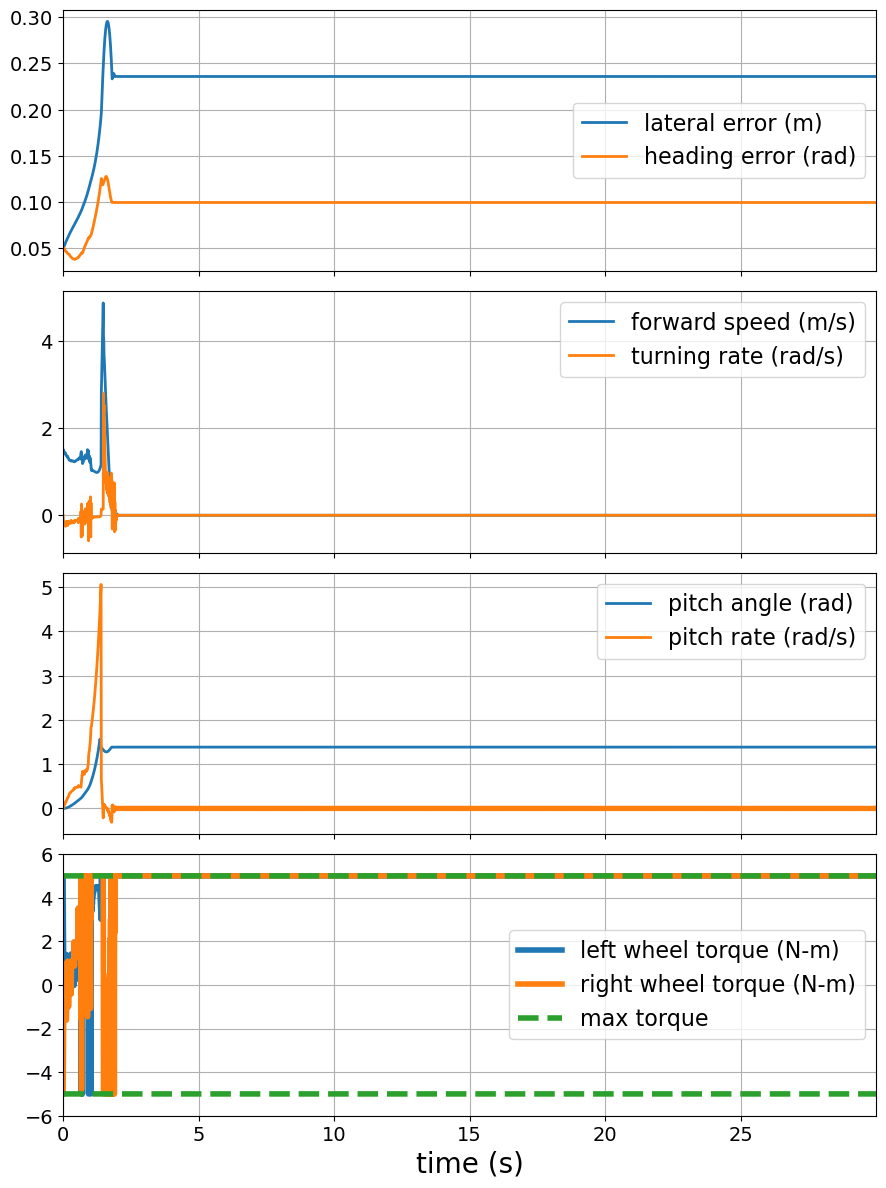

In [26]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# First subplot
ax[0].plot(data['t'], data['lateral_error'], label='lateral error (m)', linewidth=2)
ax[0].plot(data['t'], data['heading_error'], label='heading error (rad)', linewidth=2)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Second subplot
ax[1].plot(data['t'], data['forward_speed'], label='forward speed (m/s)', linewidth=2)
ax[1].plot(data['t'], data['turning_rate'], label='turning rate (rad/s)', linewidth=2)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Third subplot
ax[2].plot(data['t'], data['pitch_angle'], label='pitch angle (rad)', linewidth=2)
ax[2].plot(data['t'], data['pitch_rate'], label='pitch rate (rad/s)', linewidth=2)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Fourth subplot
ax[3].plot(data['t'], data['tau_left'], label='left wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], data['tau_right'], label='right wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()